# INSTACART MARKET BASKET ANALYSIS

This notebook is Part 2 of the workflow. 
Files are saved in SQL: `'./all/instadb.db'`

Business Problem
* Solution for product reorder - we will be working on this first)

Two main approaches in answering the challenge:
1. Item - item collaborative filtering (using Turi Create library), experimented on:
        - Continuous Value (Purchase Count)
        - Binary Value (purchase/ not purchased)
        - Scaled Value (Normalized purchase count from 0 to 1)
    - Each experimented with two calculations: 
        - Cosine Similarity
        - Pearson

2. Association Rules Mining with Apriori Algorithm

Evaluation Metric: 
* RMSE
* Recall/ Precision 

Review of database architecture (csv has since been loaded into SQL):

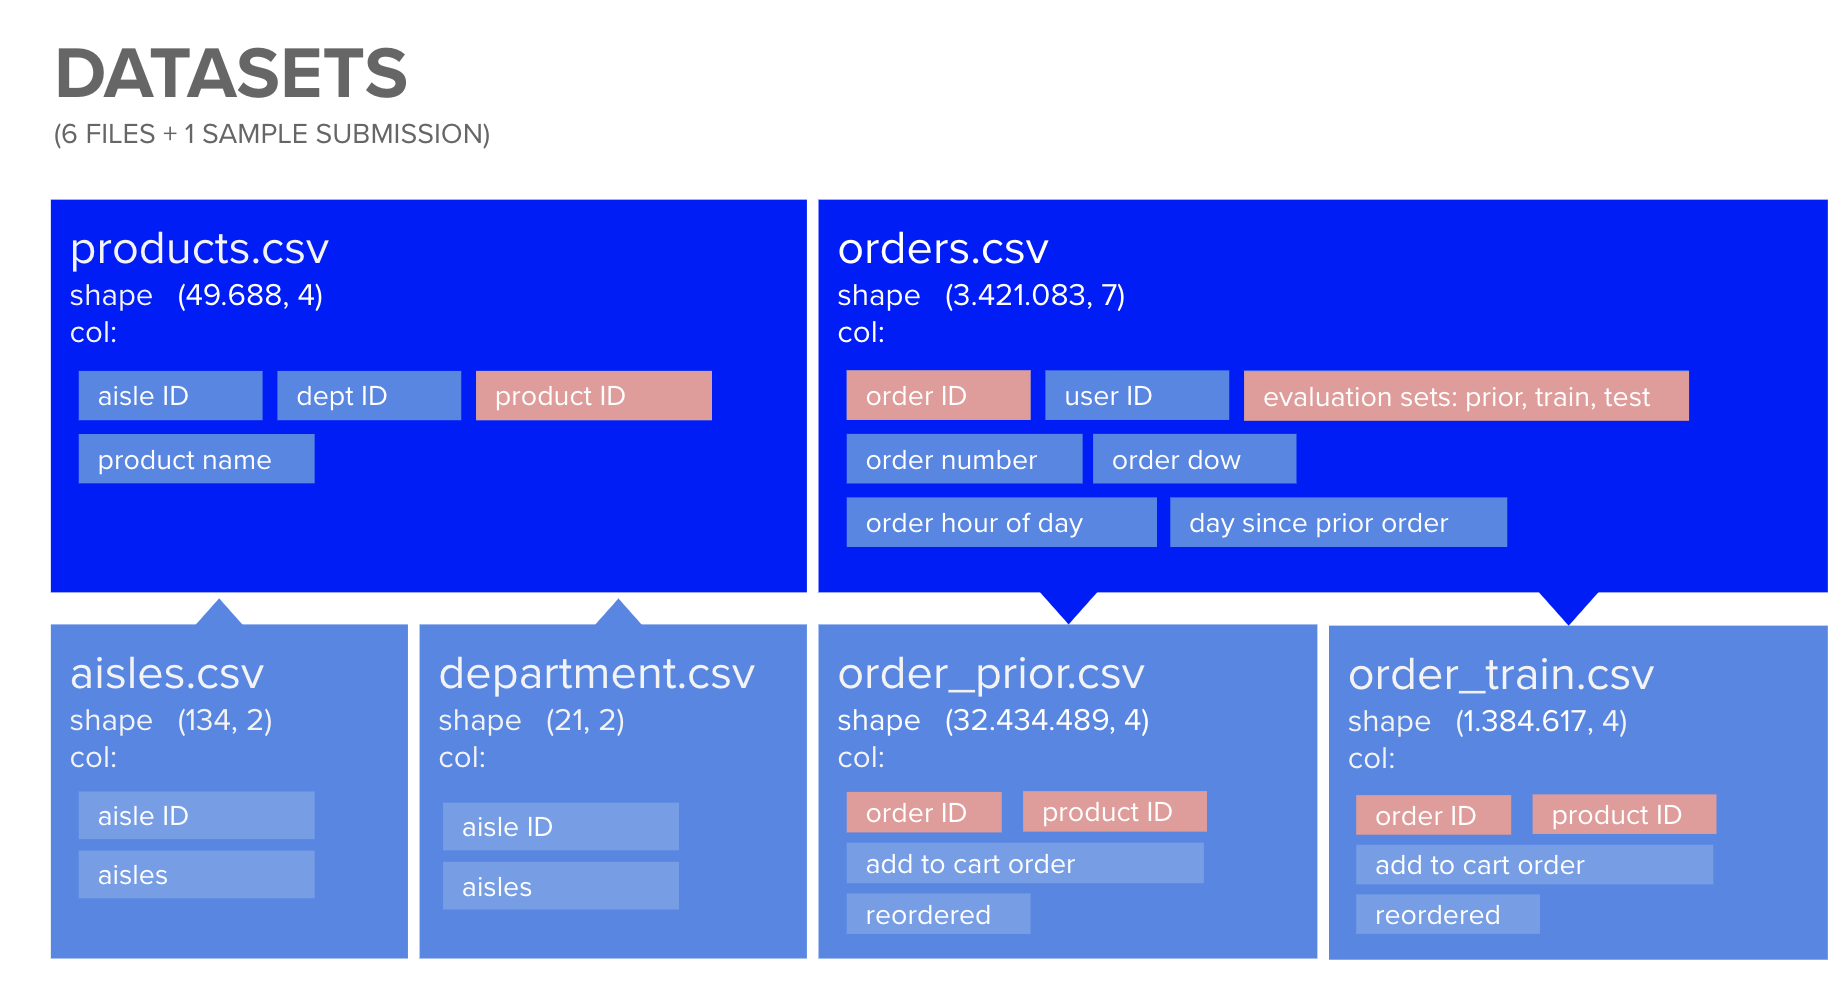


In [1]:
############# IMPORT MODULES & PACKAGES ###############

import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import time

import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#SQL
from pandas.io import sql
import sqlite3
sqlite_db = './all/instadb.db'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

## 1. FEATURE ENGINEERING & SELECTION

#### Combine order and product features

In [2]:
orders_prior_df = pd.read_sql('SELECT * FROM orders WHERE orders."eval_set" = "prior"', con = conn)
orders_train_df = pd.read_sql('SELECT * FROM orders WHERE orders."eval_set" = "train"', con = conn)
orders_test_df = pd.read_sql('SELECT * FROM orders WHERE orders."eval_set" = "test"', con = conn)
orders_products_prior_df = pd.read_sql('SELECT * FROM order_products__prior', con = conn)
orders_products_train_df = pd.read_sql('SELECT * FROM order_products__train', con = conn)
products_train_df = pd.read_sql('SELECT * FROM products', con = conn)

In [3]:
orders_prior_combined = pd.merge(pd.merge(orders_prior_df, orders_products_prior_df, on='order_id'), products_train_df, how='left', on='product_id')
orders_train_combined = pd.merge(pd.merge(orders_train_df, orders_products_train_df, on='order_id'), products_train_df, how='left', on='product_id')

orders_prior_combined.shape, orders_train_combined.shape

((32434489, 13), (1384617, 13))

In [144]:
len(orders_prior_combined.user_id.unique())

206209

In [143]:
len(orders_prior_combined.product_id.unique())

49677

In [4]:
def str_to_int (data):
    col = ['order_number', 'order_dow', 'order_hour_of_day', 'add_to_cart_order', 'reordered', 'product_id', 'user_id']
    for i in col:
        data[i] = data[i].astype(int)

str_to_int(orders_prior_combined)
str_to_int(orders_train_combined)

In [5]:
#push it back to SQL

#orders_prior_combined.to_sql(name = 'orders_prior_combined', con = conn, if_exists = 'replace', index = False)
#orders_train_combined.to_sql(name = 'orders_train_combined', con = conn, if_exists = 'replace', index = False)

In [6]:
#Test with a subset of the data and create utility matrix
#test_prior = orders_prior_combined.sample(10000).reset_index()
#test_prior = test_prior.drop('index', axis=1)
#test_prior_s = test_prior[['order_id', 'user_id', 'order_number']]
#test_prior_s = test_prior_s.sort_values(by='order_number').drop_duplicates()

In [7]:
#Utility Matrix
#test_prior_s = test_prior_s.pivot(index='user_id', columns='order_number', values='order_id')
#test_prior_s.head(50)

#Meh... not very useful

### Test with One User

In [8]:
## Test with one user who purchase regularly
orders_prior_combined[orders_prior_combined.order_number == 20].sample(10).user_id.unique()

array([157585,  36497,  42980, 163383,  73099,  69740, 189737, 108276,
       198305,  85202])

In [9]:
## Test with one user who purchase regularly = user id 50598
redundant_list = ['index', 'eval_set']
one_user_test = orders_prior_combined[orders_prior_combined.user_id == 50598].reset_index().drop(redundant_list, axis=1)
one_user_test.head(5)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2143209,50598,1,1,14,,44632,1,0,Sparkling Water Grapefruit,115,7
1,2143209,50598,1,1,14,,35221,2,0,Lime Sparkling Water,115,7
2,2143209,50598,1,1,14,,26620,3,0,Peach Pear Flavored Sparkling Water,115,7
3,2143209,50598,1,1,14,,14947,4,0,Pure Sparkling Water,115,7
4,2143209,50598,1,1,14,,36192,5,0,Kool Ranch Kale Chips,50,19


In [10]:
one_user_test_pivot_order_num = one_user_test.pivot(index='product_name', columns='order_number', values='reordered')
one_user_test_pivot_order_num.head(30)

order_number,1,2,3,4,5,6,7,8,9,10,...,59,60,61,62,63,64,65,66,67,68
product_name,,,,,,,,,,,,,,,,,,,,,
100% Recycled Paper Towels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70% Dark Chocolate With Coconut Bar,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Acai Berry Chia Bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
All Natural Maple Almond Butter,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
Almond Breeze Original Almond Milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Almond Butter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Ambrosia, Medium Roast",NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0
Ancient Grain Original Granola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
Annie Peely Fruit 4.5 Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#From the above it seems that our test user has a few items she repeatedly purchase
one_user_test1 = one_user_test[one_user_test.product_name=='Ambrosia, Medium Roast'].copy()
one_user_test1['purchase_num'] = np.array([y+1 for y in range(len(one_user_test1))])

In [12]:
one_user_test1

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,purchase_num
35,1483815,50598,4,1,13,7.0,4232,2,0,"Ambrosia, Medium Roast",26,7,1
140,924517,50598,11,1,13,5.0,4232,11,1,"Ambrosia, Medium Roast",26,7,2
161,1804307,50598,13,1,13,5.0,4232,8,1,"Ambrosia, Medium Roast",26,7,3
188,3358133,50598,14,1,14,7.0,4232,10,1,"Ambrosia, Medium Roast",26,7,4
239,2181892,50598,16,1,14,5.0,4232,9,1,"Ambrosia, Medium Roast",26,7,5
275,1531622,50598,18,2,11,4.0,4232,16,1,"Ambrosia, Medium Roast",26,7,6
339,2472652,50598,21,1,11,7.0,4232,30,1,"Ambrosia, Medium Roast",26,7,7
366,1879178,50598,23,1,9,5.0,4232,1,1,"Ambrosia, Medium Roast",26,7,8
403,85292,50598,25,1,14,5.0,4232,8,1,"Ambrosia, Medium Roast",26,7,9
447,1650329,50598,27,3,10,2.0,4232,6,1,"Ambrosia, Medium Roast",26,7,10


Insights:

- Some users may have patterns in their purchases, such as our test user (let's call her Jane). Jane purchase Ambrosia, Medium Roast the first time on her fourth order and since the 11th order, the item became a staple in her basket almost every 7 - 14 days, save for two times this lapsed. In total she purchase 24 coffee.
- It is then reasonable to assume that recommending Ambrosia, Medium Roast to her once every 7 - 14 days from her previous pruchase make sense.

### Create a subset from the prior data

In [13]:
#Tried looping through the dataset and kernel died a few times. Let's continue with a subset
#Let's look at those users who purchased > median purchase number (10) 
#Limit to 20K user ids, otherwise programme won't run

number_of_samples = 20000
temp_prior_subset_id = orders_prior_combined[orders_prior_combined.order_number > 10].user_id
temp_prior_subset_id = list(set(temp_prior_subset_id))
prior_subset_id = random.choices(population=temp_prior_subset_id, k=number_of_samples)

In [14]:
prior_subset= orders_prior_combined[orders_prior_combined.user_id.isin(prior_subset_id)]
print('number of unique user in subset: ', len(prior_subset.user_id.unique()), '\nnumber of orders: ', len(prior_subset))

number of unique user in subset:  18014 
number of orders:  5044861


In [142]:
len(prior_subset.product_id.unique())

43282

In [15]:
list(set(temp_prior_subset_id)).__len__()

93881

In [16]:
prior_subset.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
254,1374495,3,prior,1,1,14,,9387,1,0,Granny Smith Apples,24,4
255,1374495,3,prior,1,1,14,,17668,2,0,Unsweetened Chocolate Almond Breeze Almond Milk,91,16
256,1374495,3,prior,1,1,14,,15143,3,0,Blueberry Pint,24,4
257,1374495,3,prior,1,1,14,,16797,4,0,Strawberries,24,4
258,1374495,3,prior,1,1,14,,39190,5,0,Vanilla Unsweetened Almond Milk,91,16


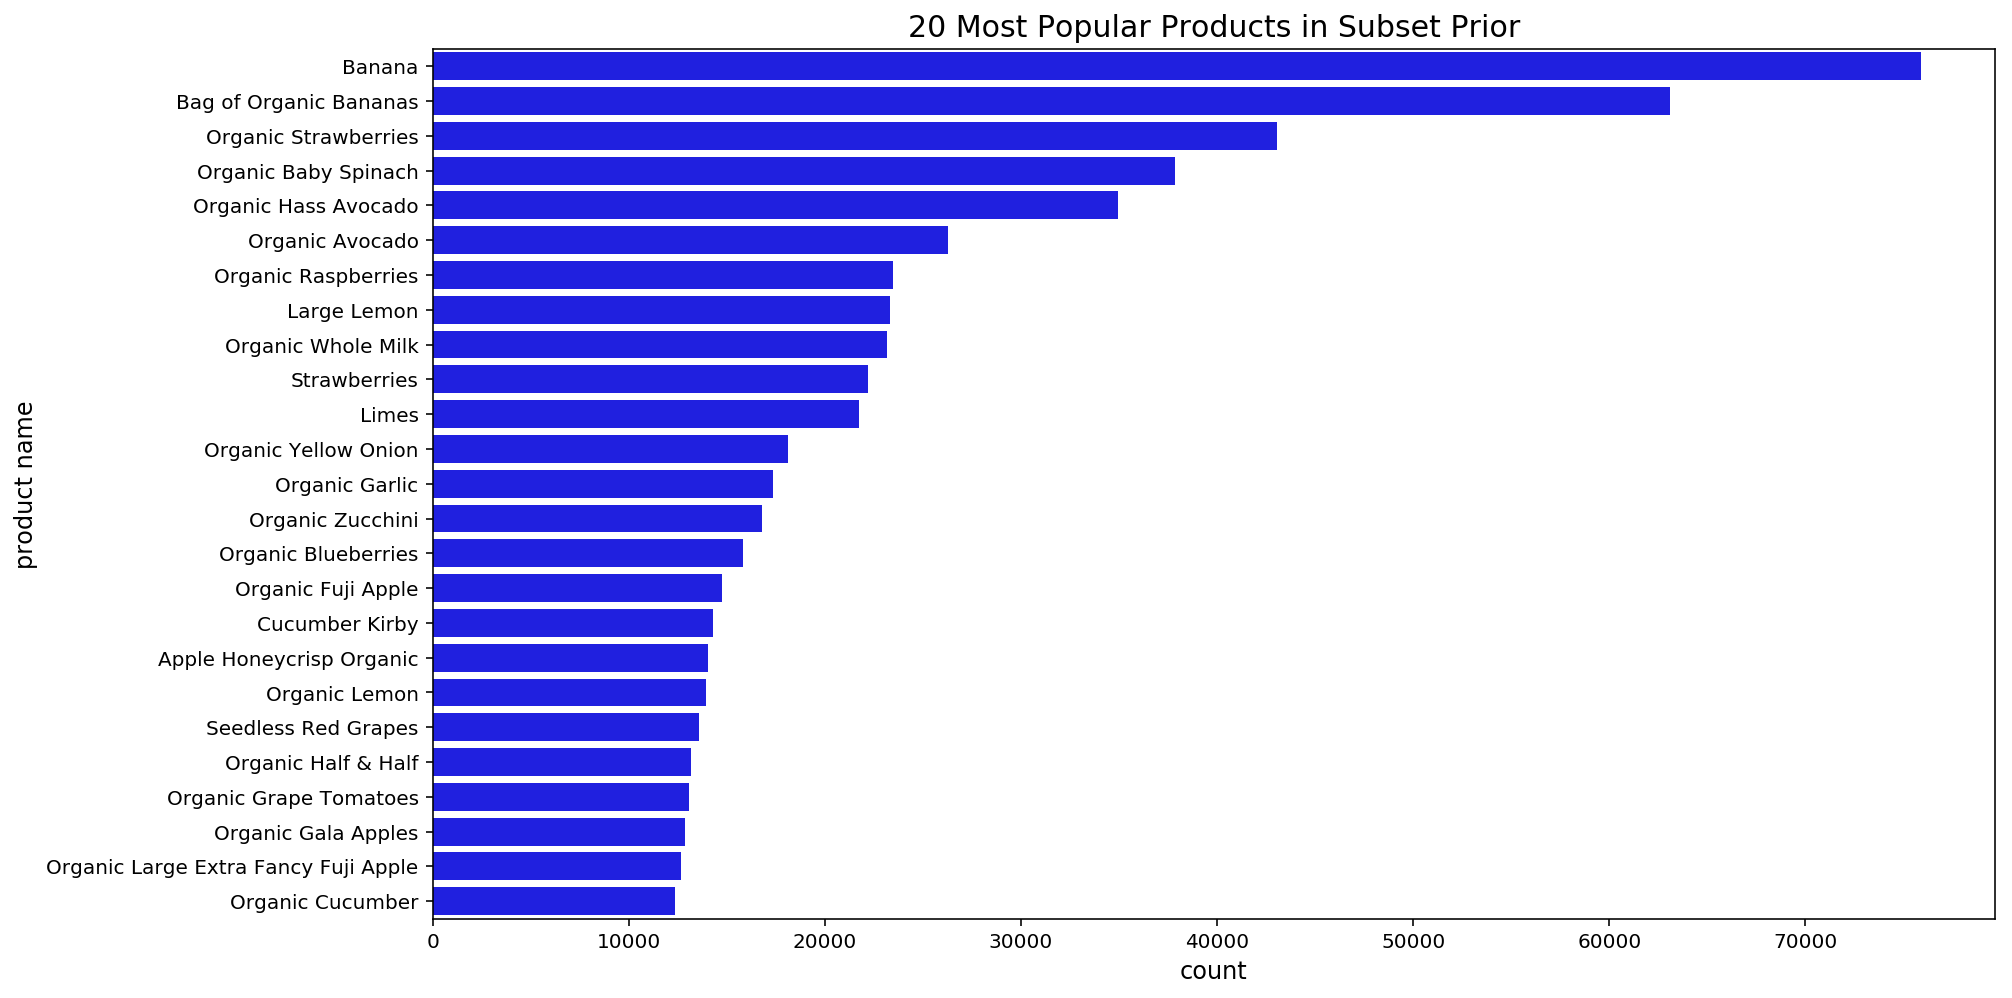

In [17]:
#Look at the most popular product

topseller_subset = pd.DataFrame(prior_subset.groupby(['department_id', 'product_name'])['order_number'].count().reset_index())
topseller_subset_all_time = topseller_subset.sort_values(by='order_number', ascending=False).head(25)

_ = plt.figure(figsize=(14,8))
_ = sns.barplot(topseller_subset_all_time.order_number, topseller_subset_all_time.product_name, color='blue')
_ = plt.title('20 Most Popular Products in Subset Prior', fontsize=15)
_ = plt.ylabel('product name', fontsize=12)
_ = plt.xlabel('count', fontsize=12)


#### Note:

The dataset is a bit different from the original prior, but the top 10 most sold items are the same. We'll make do with this.

In [18]:
#Save as backup
prior_subset.to_sql(name = 'prior_subset', con = conn, if_exists = 'replace', index = False)

### Engineered Feature 1: Count purchase number

In [19]:
#n = max(temp_data.product_id.unique())
#listofzeros = [0] * (n +1)
#purchase_num = [0] * len(temp_data.product_name)

#for i in range(len(temp_data.product_name)):
#    temp_product = temp_data.product_name[i]
#    temp_id = temp_data.product_id[i]
#    listofzeros[temp_id] = listofzeros[temp_id] + 1
#    purchase_num[i] = listofzeros[temp_id]

#def count_purchase_num(data):
    
#    n = max(data.product_id.unique())
#    listofzeros = [0] * (n +1)
#    purchase_num = [0] * len(data.product_name)

#    for i in range(len(data.product_name)):
#        temp_product = data.product_name[i]
#        temp_id = data.product_id[i]
#        listofzeros[temp_id] = listofzeros[temp_id] + 1
#        purchase_num[i] = listofzeros[temp_id]

#    return purchase_num

## Run the function to the Subset
#prior_subset = prior_subset.reset_index()
#purchase_num = count_purchase_num(prior_subset)
#prior_subset['purchase_num'] = purchase_num

In [20]:
prior_subset_final = prior_subset.loc[:, ['user_id', 'product_id']]

In [21]:
s=time.time()

prior_subset_final = pd.melt(prior_subset_final.set_index('user_id')['product_id'].apply(pd.Series).reset_index(), 
             id_vars=['user_id'],
             value_name='product_id') \
    .dropna().drop(['variable'], axis=1) \
    .groupby(['user_id', 'product_id']) \
    .agg({'product_id': 'count'}) \
    .rename(columns={'product_id': 'purchase_count'}) \
    .reset_index() \
    .rename(columns={'product_id': 'product_id'})
    
prior_subset_final['product_id'] = prior_subset_final['product_id'].astype(np.int64)

print("Execution time:", round((time.time()-s)/60,2), "minutes")

Execution time: 24.68 minutes


In [22]:
#Save as backup
prior_subset_final.to_sql(name = 'prior_subset_final', con = conn, if_exists = 'replace', index = False)

In [23]:
print(prior_subset_final.shape)

(1779662, 3)


In [24]:
#Check for abnormalities
prior_subset_final.sort_values(by='purchase_count', ascending=False).head(10)

,user_id,product_id,purchase_count
312411,36335,11784,95
1274705,147173,15424,94
635310,74315,31981,94
1450769,166786,38164,93
1555622,179667,40174,92
1450738,166786,23737,92
1639339,189425,24852,92
26126,3377,38251,91
635261,74315,24852,90
823257,94764,2120,90


### Engineered Feature 2: Scaled purchase count (0 to 1)

In [25]:
#We can normalize the puchase count with value from 0-1 (1 being most number of purhcase and 0 means no purhcased)
data_matrix = pd.pivot_table(prior_subset_final, values='purchase_count', index='user_id', columns='product_id')
data_matrix.head()

product_id,1,2,3,4,5,6,7,8,9,10,...,49678,49679,49680,49681,49682,49683,49685,49686,49687,49688
user_id,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
data_matrix_norm = (data_matrix-data_matrix.min())/(data_matrix.max()-data_matrix.min())
print(data_matrix_norm.shape)
data_matrix_norm.head()

(18014, 43282)


product_id,1,2,3,4,5,6,7,8,9,10,...,49678,49679,49680,49681,49682,49683,49685,49686,49687,49688
user_id,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# create a table for input to model
s=time.time()
d = data_matrix_norm.reset_index()
d.index.names = ['scaled_purchase_freq']
data_norm = pd.melt(d, id_vars=['user_id'], value_name='scaled_purchase_freq').dropna()

print("Execution time:", round((time.time()-s)/60,2), "minutes")
print(data_norm.shape)
data_norm.head(15)

Execution time: 6.08 minutes
(1750593, 3)


,user_id,product_id,scaled_purchase_freq
13,138,1,0.05
131,1540,1,0.80
336,4122,1,0.00
715,8703,1,0.00
926,11243,1,0.00
941,11448,1,0.25
1069,12892,1,0.00
1100,13141,1,0.35
1252,14910,1,0.10
1583,18586,1,0.05


### Engineered Feature 3: Binary dummy values (purchased/ not purchased)

In [28]:
dummy = []
for i in data_norm.scaled_purchase_freq:
    if i == 0:
        dummy.append(0)
    else:
        dummy.append(1)

In [29]:
data_dummy = data_norm.copy()
data_dummy['purchase_dummy'] = dummy

In [146]:
data_dummy.head(10)

,user_id,product_id,scaled_purchase_freq,purchase_dummy
13,138,1,0.05,1
131,1540,1,0.80,1
336,4122,1,0.00,0
715,8703,1,0.00,0
926,11243,1,0.00,0
941,11448,1,0.25,1
1069,12892,1,0.00,0
1100,13141,1,0.35,1
1252,14910,1,0.10,1
1583,18586,1,0.05,1


## 2. MODELING

The Turi Create recommender toolkit provides a unified interface to train a variety of recommender models and use them to make recommendations.

Recommender models can be created using `turicreate.recommender.create()` or loaded from a previously saved model `using turicreate.load_model()`. The input data must be an `SFrame` with a column containing user ids, a column containing item ids, and optionally a column containing target values such as movie ratings, etc. When a target is not provided (as is the case in implicit feedback settings), then a collaborative filtering model based on item-item similarity is returned. For more details, please see https://turi.com/learn/userguide/recommender/introduction.html

In [30]:
#Import Modules

import turicreate as tc
from sklearn.cross_validation import train_test_split

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Train test split data

In [31]:
train, test = train_test_split(prior_subset_final, test_size = .2)
print(train.shape, test.shape)

(1423729, 3) (355933, 3)


In [32]:
# Using turicreate library, we convert dataframe to SFrame - this will be useful in the modeling part

train_data = tc.SFrame(train)
test_data = tc.SFrame(test)

In [33]:
train_data.head()

user_id,product_id,purchase_count
187604,1037,1
49673,5646,2
38204,17794,1
148124,1752,2
133716,45246,1
164738,3844,1
115891,46906,1
60473,12939,1
149622,1202,1
12953,22950,2


In [34]:
test_data.head()

user_id,product_id,purchase_count
73663,20323,3
88797,25340,6
35864,6287,6
130428,18677,1
176549,45,2
151058,9837,1
175995,17061,2
58177,34249,1
144483,31717,2
75705,46979,1


In [35]:
#Train test split Normalized Data
train_norm, test_norm = train_test_split(data_norm, test_size = .2)
train_data_norm = tc.SFrame(train_norm)
test_data_norm = tc.SFrame(test_norm)

In [36]:
#Train test split dummy
train_dummy, test_dummy = train_test_split(data_dummy, test_size = .2)
train_data_dummy = tc.SFrame(train_dummy)
test_data_dummy = tc.SFrame(test_dummy)

### Baseline Model: Popularity Model

The Popularity Model ranks an item according to its overall popularity.

When making recommendations, the items are scored by the number of times it is seen in the training set. The item scores are the same for all users. Hence the recommendations are not tailored for individuals.

The Popularity Recommender is simple and fast and provides a reasonable baseline. It can work well when observation data is sparse. It can be used as a “background” model for new users.

#### Using purchase_count

In [37]:
#Input parameters required by turicreate recommender module
user_id = 'user_id'
item_id = 'product_id'
users_to_recommend = list(prior_subset_final.user_id.unique())
n_rec = 5 # number of items to recommend
n_display = 25

In [38]:
target = 'purchase_count'
popularity_model = tc.popularity_recommender.create(train_data, user_id=user_id, item_id=item_id, target=target)

Recsys training: model = popularity

Preparing data set.

Data has 1423729 observations with 18012 users and 41663 items.

Data prepared in: 0.760297s

1423729 observations to process; with 41663 unique items.

In [39]:
# Get recommendations for a list of users to recommend (from customers file)
# Printed below is head / top 30 rows for first 3 customers with 10 recommendations each

popularity_recomm = popularity_model.recommend(users=users_to_recommend, k=n_rec)
popularity_recomm.print_rows(n_display)

recommendations finished on 1000/18014 queries. users per second: 3294.23

recommendations finished on 2000/18014 queries. users per second: 5149.26

recommendations finished on 3000/18014 queries. users per second: 6414.63

recommendations finished on 4000/18014 queries. users per second: 7140.08

recommendations finished on 5000/18014 queries. users per second: 7829.15

recommendations finished on 6000/18014 queries. users per second: 8270.59

recommendations finished on 7000/18014 queries. users per second: 8576.38

recommendations finished on 8000/18014 queries. users per second: 8870.96

recommendations finished on 9000/18014 queries. users per second: 9077.38

recommendations finished on 10000/18014 queries. users per second: 9275.78

recommendations finished on 11000/18014 queries. users per second: 9371.03

recommendations finished on 12000/18014 queries. users per second: 9495.26

recommendations finished on 13000/18014 queries. users per second: 9599.58

recommendations finished on 14000/18014 queries. users per second: 9637.06

recommendations finished on 15000/18014 queries. users per second: 9695.37

recommendations finished on 16000/18014 queries. users per second: 9704.32

recommendations finished on 17000/18014 queries. users per second: 9660.96

recommendations finished on 18000/18014 queries. users per second: 9450.36

+---------+------------+-------+------+
| user_id | product_id | score | rank |
+---------+------------+-------+------+
|    3    |    2075    |  59.0 |  1   |
|    3    |   37292    |  50.0 |  2   |
|    3    |   38251    |  46.5 |  3   |
|    3    |   26524    |  36.0 |  4   |
|    3    |    3510    |  33.0 |  5   |
|    22   |    2075    |  59.0 |  1   |
|    22   |   37292    |  50.0 |  2   |
|    22   |   38251    |  46.5 |  3   |
|    22   |   26524    |  36.0 |  4   |
|    22   |    3510    |  33.0 |  5   |
|    31   |    2075    |  59.0 |  1   |
|    31   |   37292    |  50.0 |  2   |
|    31   |   38251    |  46.5 |  3   |
|    31   |   26524    |  36.0 |  4   |
|    31   |    3510    |  33.0 |  5   |
|    37   |    2075    |  59.0 |  1   |
|    37   |   37292    |  50.0 |  2   |
|    37   |   38251    |  46.5 |  3   |
|    37   |   26524    |  36.0 |  4   |
|    37   |    3510    |  33.0 |  5   |
|    50   |    2075    |  59.0 |  1   |
|    50   |   37292    |  50.0 |  2   |


In [40]:
#Define functions to select model in Turicreate Library

def model (train_data, model_name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if model_name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    
    elif model_name =='cosine':
        model = tc.recommender.item_similarity_recommender.create(train_data,
                                          user_id=user_id,
                                          item_id=item_id,
                                          target=target,
                                         similarity_type='cosine')
        
    elif model_name =='pearson':
        model = tc.recommender.item_similarity_recommender.create(train_data,
                                          user_id=user_id,
                                          item_id=item_id,
                                          target=target,
                                         similarity_type='pearson')
        
    elif model_name =='jaccard':
        model = tc.recommender.item_similarity_recommender.create(train_data,
                                          user_id=user_id,
                                          item_id=item_id,
                                          target=target,
                                         similarity_type='jaccard')
    
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)
    return model

#### Use Purchase Dummy

In [41]:
name = 'popularity'
target = 'purchase_dummy'
pop_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = popularity

Warning: Ignoring columns scaled_purchase_freq;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1400474 observations with 18011 users and 30178 items.

Data prepared in: 1.08508s

1400474 observations to process; with 30178 unique items.

recommendations finished on 1000/18014 queries. users per second: 2827.32

recommendations finished on 2000/18014 queries. users per second: 4855.8

recommendations finished on 3000/18014 queries. users per second: 6277.67

recommendations finished on 4000/18014 queries. users per second: 7442.62

recommendations finished on 5000/18014 queries. users per second: 8267.58

recommendations finished on 6000/18014 queries. users per second: 9014.52

recommendations finished on 7000/18014 queries. users per second: 9652.24

recommendations finished on 8000/18014 queries. users per second: 10143.1

recommendations finished on 9000/18014 queries. users per second: 10533.6

recommendations finished on 10000/18014 queries. users per second: 10936.3

recommendations finished on 11000/18014 queries. users per second: 11289.5

recommendations finished on 12000/18014 queries. users per second: 11540.2

recommendations finished on 13000/18014 queries. users per second: 11780.7

recommendations finished on 14000/18014 queries. users per second: 12027

recommendations finished on 15000/18014 queries. users per second: 12260.5

recommendations finished on 16000/18014 queries. users per second: 12335

recommendations finished on 17000/18014 queries. users per second: 12485.2

recommendations finished on 18000/18014 queries. users per second: 12560.6

+---------+------------+-------+------+
| user_id | product_id | score | rank |
+---------+------------+-------+------+
|    3    |   12263    |  1.0  |  1   |
|    3    |   12947    |  1.0  |  2   |
|    3    |   34152    |  1.0  |  3   |
|    3    |   21945    |  1.0  |  4   |
|    3    |    9369    |  1.0  |  5   |
|    22   |   12263    |  1.0  |  1   |
|    22   |   12947    |  1.0  |  2   |
|    22   |   34152    |  1.0  |  3   |
|    22   |   21945    |  1.0  |  4   |
|    22   |    9369    |  1.0  |  5   |
|    31   |   12263    |  1.0  |  1   |
|    31   |   12947    |  1.0  |  2   |
|    31   |   34152    |  1.0  |  3   |
|    31   |   21945    |  1.0  |  4   |
|    31   |    9369    |  1.0  |  5   |
|    37   |   12263    |  1.0  |  1   |
|    37   |   12947    |  1.0  |  2   |
|    37   |   34152    |  1.0  |  3   |
|    37   |   21945    |  1.0  |  4   |
|    37   |    9369    |  1.0  |  5   |
|    50   |   12263    |  1.0  |  1   |
|    50   |   12947    |  1.0  |  2   |


#### Use Normalized Purchase Count

In [42]:
name = 'popularity'
target = 'scaled_purchase_freq'
pop_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = popularity

Preparing data set.

Data has 1400474 observations with 18013 users and 30187 items.

Data prepared in: 1.26343s

1400474 observations to process; with 30187 unique items.

recommendations finished on 1000/18014 queries. users per second: 2537.14

recommendations finished on 2000/18014 queries. users per second: 3841.29

recommendations finished on 3000/18014 queries. users per second: 4847.96

recommendations finished on 4000/18014 queries. users per second: 5309.29

recommendations finished on 5000/18014 queries. users per second: 5768.63

recommendations finished on 6000/18014 queries. users per second: 5915.17

recommendations finished on 7000/18014 queries. users per second: 6230.73

recommendations finished on 8000/18014 queries. users per second: 6366.46

recommendations finished on 9000/18014 queries. users per second: 6593.4

recommendations finished on 10000/18014 queries. users per second: 6558.08

recommendations finished on 11000/18014 queries. users per second: 6541.43

recommendations finished on 12000/18014 queries. users per second: 6468.25

recommendations finished on 13000/18014 queries. users per second: 6358.63

recommendations finished on 14000/18014 queries. users per second: 6121.12

recommendations finished on 15000/18014 queries. users per second: 6083.69

recommendations finished on 16000/18014 queries. users per second: 5477.17

recommendations finished on 17000/18014 queries. users per second: 5540.27

recommendations finished on 18000/18014 queries. users per second: 5473.91

+---------+------------+-------+------+
| user_id | product_id | score | rank |
+---------+------------+-------+------+
|    3    |   37456    |  1.0  |  1   |
|    3    |    7985    |  1.0  |  2   |
|    3    |   26619    |  1.0  |  3   |
|    3    |    3569    |  1.0  |  4   |
|    3    |   26430    |  1.0  |  5   |
|    22   |   37456    |  1.0  |  1   |
|    22   |    7985    |  1.0  |  2   |
|    22   |   26619    |  1.0  |  3   |
|    22   |    3569    |  1.0  |  4   |
|    22   |   26430    |  1.0  |  5   |
|    31   |   37456    |  1.0  |  1   |
|    31   |    7985    |  1.0  |  2   |
|    31   |   26619    |  1.0  |  3   |
|    31   |    3569    |  1.0  |  4   |
|    31   |   26430    |  1.0  |  5   |
|    37   |   37456    |  1.0  |  1   |
|    37   |    7985    |  1.0  |  2   |
|    37   |   26619    |  1.0  |  3   |
|    37   |    3569    |  1.0  |  4   |
|    37   |   26430    |  1.0  |  5   |
|    50   |   37456    |  1.0  |  1   |
|    50   |    7985    |  1.0  |  2   |


Insight:
* The model above takes 5 most popular items and recommend them to 10 different users.
* With the popularity model, the most popular items across users are recommended. Although each model differs in the items recommended, each model recommend the same 5 things to every user. 
* The grouping below shows 10 most recommended items by using purchase chounts divided by total number of customers. The first few products are bought at least 30 times on average in the training set. 
* ** Why not banana?** It is possible that although banana is the best selling product, it was only purchased by a segment of the customer, whereas the items below were purchased across the customers/ banana doesn't generalize very well. We can prove this

In [43]:
#Look at top 20 most recommended item
train_products_by_popularity = train.groupby(by=item_id)['purchase_count'].mean().sort_values(ascending=False).head(20)
train_products_by_popularity 

product_id
2075     59.0
37292    50.0
38251    46.5
26524    36.0
3510     33.0
45240    30.0
7985     30.0
2584     30.0
16252    27.0
27782    27.0
12351    27.0
700      26.0
45035    25.5
8647     25.0
45328    25.0
37405    24.0
24748    24.0
47554    24.0
1936     23.5
41938    23.5
Name: purchase_count, dtype: float64

In [98]:
### Helper Function###
def find_product_name (data):
    product_names = [] 
    for i in data:
        list_product_names = prior_subset[prior_subset.product_id == i]['product_name'].values[0]
        product_names.append(list_product_names)        
    return product_names

In [99]:
find_product_name(train_products_by_popularity.index)

['Serenity Ultimate Extrema Overnight Pads',
 'Organic Dark Chocolate Bar with Sea Salt and Turbinado Cane Sugar',
 'Benchbreak Chardonnay',
 'Organic Chewy Soft Caramel with Pecans Chocolate Covered Candy Bar',
 'Swedish Oatmeal Pancakes',
 'Sausages, Little Pork',
 'Gluten-Free Reduced Sodium Popcorn',
 'Donut Sticks',
 'Diet Pepsi Wild Cherry',
 'Sesame Millet Bread',
 'Smooth & Sweet Citrus Punch',
 'Jet Fuel Dark Roast Whole Bean Coffee',
 'Coffee Flavor Yogurt',
 'Apple Kiwi Strawberry Concentrate Frozen',
 'Flavored Vodka, Peach',
 'Frosted Mini-Wheats Little Bites Chocolate Cereal',
 'Orange Liquid Drink Mix',
 'Mocha Latte & Dark Chocolate Swirl, Silky Smooth',
 'Diet Tangerine Lime Premium Soda, Zero Calories, Sugar Free, No Caffeine',
 'Solar Yerba Mate Brew']

In [67]:
#Look at basket of a user ID to see if there's any overlap
prior_subset[prior_subset.user_id == 3][['product_id','product_name']].groupby(['product_id', 'product_name']).count()

,
product_id,product_name
248,Dried Sweetened Cranberries
1005,China Green Tips Green Tea
1819,All Natural No Stir Creamy Almond Butter
7503,Whole Almonds
8021,100% Recycled Paper Towels
9387,Granny Smith Apples
12845,Chopped Walnuts
14992,Green Beans
15143,Blueberry Pint


#### Bonus: Solving the banana mystery

In [47]:
## FIND THE REACH OF BANANA
# Go through the list of orders, if the order has banana, encode 1 otherwise 0
# Barplot between who bought banana and who didnt

bnn = []
for i in prior_subset.product_id:
    if i == 24852:
        bnn.append(1)
    else:
        bnn.append(0)

In [48]:
banana_subset = prior_subset.copy()
banana_subset['bought_banana'] = bnn

In [49]:
banana_subset_count = banana_subset[['user_id', 'bought_banana']].groupby('user_id')['bought_banana'].sum()

In [50]:
#Users who didnt buy banana vs buy banana
didnt_buy_banana = list(banana_subset_count.values).count(0)
bought_banana = len(banana_subset_count) - didnt_buy_banana

users_who_bought_banana = banana_subset_count[banana_subset_count.values > 0]
avg_banana_bought_by_users_who_bought_banana = np.mean(users_who_bought_banana.values)

In [51]:
didnt_buy_banana, bought_banana

(9857, 8157)

In [52]:
avg_banana_bought_by_users_who_bought_banana

9.301336275591517

In [53]:
#There are less people buying banana - but on average, for every banana buyer they buy 9 bananas in 30 days.
#We solved the banana mystery! 

### Collaborative Filtering Model

This model first computes the similarity between items using the observations of users who have interacted with both items. Given a similarity between item `i` and `j`, `S(i,j)`, it scores an item `j` for user `u` using a weighted average of the user’s previous observations `Iu`.

There are three choices of similarity metrics to use: ‘jaccard’, ‘cosine’ and ‘pearson’. 


### Cosine Similarity

Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B. A problem with Cosine similarity is that it does not consider the differences in the mean and variance of the ratings made to items A and B. The closer the vectors, the smaller will be the angle and the larger the cosine

In [54]:
##use purchase count
name = 'cosine'
target = 'purchase_count'
cos = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = item_similarity

Preparing data set.

Data has 1423729 observations with 18012 users and 41663 items.

Data prepared in: 0.871539s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 10.557ms                       | 5.5        |

| 45.655ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.54s                               | 0                | 29              |

| 14.51s                              | 100              | 41663           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 15.6055s

recommendations finished on 1000/18014 queries. users per second: 916.767

recommendations finished on 2000/18014 queries. users per second: 1631.7

recommendations finished on 3000/18014 queries. users per second: 2184.92

recommendations finished on 4000/18014 queries. users per second: 2565.34

recommendations finished on 5000/18014 queries. users per second: 2947.86

recommendations finished on 6000/18014 queries. users per second: 3222.68

recommendations finished on 7000/18014 queries. users per second: 3454.38

recommendations finished on 8000/18014 queries. users per second: 3381.34

recommendations finished on 9000/18014 queries. users per second: 3561.63

recommendations finished on 10000/18014 queries. users per second: 3542.37

recommendations finished on 11000/18014 queries. users per second: 3698.31

recommendations finished on 12000/18014 queries. users per second: 3839.88

recommendations finished on 13000/18014 queries. users per second: 3939.08

recommendations finished on 14000/18014 queries. users per second: 4066.81

recommendations finished on 15000/18014 queries. users per second: 4134.67

recommendations finished on 16000/18014 queries. users per second: 4207.51

recommendations finished on 17000/18014 queries. users per second: 4291.37

recommendations finished on 18000/18014 queries. users per second: 4331.02

+---------+------------+---------------------+------+
| user_id | product_id |        score        | rank |
+---------+------------+---------------------+------+
|    3    |   24852    |  0.868972319823045  |  1   |
|    3    |   19360    |  0.694736123085022  |  2   |
|    3    |   39519    |  0.6511149337658515 |  3   |
|    3    |   47209    |  0.6174163634960468 |  4   |
|    3    |   21846    |  0.5959069797625909 |  5   |
|    22   |   21846    |  0.8014224810259682 |  1   |
|    22   |   21137    |  0.593715529356684  |  2   |
|    22   |   39519    |  0.5902262989963803 |  3   |
|    22   |   47209    |  0.5833334199019841 |  4   |
|    22   |   24852    |  0.5012386696679252 |  5   |
|    31   |   21846    | 0.18507511364786247 |  1   |
|    31   |   45825    |  0.1803053582185193 |  2   |
|    31   |    9857    | 0.16867331297774063 |  3   |
|    31   |   24386    | 0.14526382049447611 |  4   |
|    31   |   24339    | 0.13446129270290075 |  5   |
|    37   |   13176    |  0.

In [55]:
##use purchase dummy
name = 'cosine'
target = 'purchase_dummy'
cos_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = item_similarity

Warning: Ignoring columns scaled_purchase_freq;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1400474 observations with 18011 users and 30178 items.

Data prepared in: 1.13995s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.892ms                        | 5.5        |

| 102.99ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.92s                               | 0                | 4               |

| 6.86s                               | 100              | 30178           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 6.94336s

recommendations finished on 1000/18014 queries. users per second: 7469.04

recommendations finished on 2000/18014 queries. users per second: 8664.84

recommendations finished on 3000/18014 queries. users per second: 9167.05

recommendations finished on 4000/18014 queries. users per second: 9261.6

recommendations finished on 5000/18014 queries. users per second: 9244.5

recommendations finished on 6000/18014 queries. users per second: 9205.38

recommendations finished on 7000/18014 queries. users per second: 9246.8

recommendations finished on 8000/18014 queries. users per second: 9270.56

recommendations finished on 9000/18014 queries. users per second: 9233.97

recommendations finished on 10000/18014 queries. users per second: 9267.56

recommendations finished on 11000/18014 queries. users per second: 9317.38

recommendations finished on 12000/18014 queries. users per second: 9275.15

recommendations finished on 13000/18014 queries. users per second: 9261.73

recommendations finished on 14000/18014 queries. users per second: 9250.72

recommendations finished on 15000/18014 queries. users per second: 9255.52

recommendations finished on 16000/18014 queries. users per second: 9218.63

recommendations finished on 17000/18014 queries. users per second: 9182.23

recommendations finished on 18000/18014 queries. users per second: 9150.2

+---------+------------+-----------------------+------+
| user_id | product_id |         score         | rank |
+---------+------------+-----------------------+------+
|    3    |   24852    |   0.0668272304534912  |  1   |
|    3    |   21903    |  0.06554720640182495  |  2   |
|    3    |   47626    |  0.05618614673614502  |  3   |
|    3    |   26209    |  0.05288460493087768  |  4   |
|    3    |   13176    |  0.04399331569671631  |  5   |
|    22   |   21137    |  0.08467748219316656  |  1   |
|    22   |   21903    |  0.08460529825904152  |  2   |
|    22   |   47209    |  0.08186234127391469  |  3   |
|    22   |   13176    |  0.07602275501598012  |  4   |
|    22   |   26209    |  0.07463746179233897  |  5   |
|    31   |   39738    |  0.00689229765138426  |  1   |
|    31   |   39607    |  0.005604974456600376 |  2   |
|    31   |    8954    |  0.005604974456600376 |  3   |
|    31   |   26277    | 0.0055858505355728255 |  4   |
|    31   |   10405    | 0.0055858505355728255 |

In [56]:
##use normalized purchase count
name = 'cosine'
target = 'scaled_purchase_freq'
cos_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = item_similarity

Preparing data set.

Data has 1400474 observations with 18013 users and 30187 items.

Data prepared in: 0.987882s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 6.464ms                        | 5.5        |

| 64.863ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.87s                               | 0                | 1               |

| 6.44s                               | 100              | 30187           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 6.52362s

recommendations finished on 1000/18014 queries. users per second: 5350.8

recommendations finished on 2000/18014 queries. users per second: 5601.57

recommendations finished on 3000/18014 queries. users per second: 5542.67

recommendations finished on 4000/18014 queries. users per second: 5485.21

recommendations finished on 5000/18014 queries. users per second: 5612.47

recommendations finished on 6000/18014 queries. users per second: 5682.32

recommendations finished on 7000/18014 queries. users per second: 5618.97

recommendations finished on 8000/18014 queries. users per second: 5601.85

recommendations finished on 9000/18014 queries. users per second: 5708.6

recommendations finished on 10000/18014 queries. users per second: 5825.68

recommendations finished on 11000/18014 queries. users per second: 5924.5

recommendations finished on 12000/18014 queries. users per second: 5931.2

recommendations finished on 13000/18014 queries. users per second: 5916.27

recommendations finished on 14000/18014 queries. users per second: 5957.1

recommendations finished on 15000/18014 queries. users per second: 5979.4

recommendations finished on 16000/18014 queries. users per second: 5982.16

recommendations finished on 17000/18014 queries. users per second: 5978.12

recommendations finished on 18000/18014 queries. users per second: 5917.23

+---------+------------+-----------------------+------+
| user_id | product_id |         score         | rank |
+---------+------------+-----------------------+------+
|    3    |   12760    |  0.005200463036696116 |  1   |
|    3    |   43647    |  0.004634733001391093 |  2   |
|    3    |    1203    |  0.004181529084841411 |  3   |
|    3    |   20406    |  0.004162070651849111 |  4   |
|    3    |   24852    |  0.004119542737801869 |  5   |
|    22   |   24964    | 0.0037491564397458678 |  1   |
|    22   |   21137    | 0.0036340466252079715 |  2   |
|    22   |   47209    | 0.0033187049406546132 |  3   |
|    22   |   13176    |  0.002960412590591996 |  4   |
|    22   |   45007    |  0.002670422748283104 |  5   |
|    31   |   48735    |  0.005014941624715818 |  1   |
|    31   |   12688    |  0.005014941624715818 |  2   |
|    31   |   14016    |  0.005014941624715818 |  3   |
|    31   |   48847    |  0.004321076345781908 |  4   |
|    31   |   39607    |  0.003934043941768349 |

### Pearson Similarity

Examine pearson coefficient between two factors where the effects of means and variance have been removed 

In [57]:
##use purchase count
name = 'pearson'
target = 'purchase_count'
pearson = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = item_similarity

Preparing data set.

Data has 1423729 observations with 18012 users and 41663 items.

Data prepared in: 0.768286s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 7.673ms                        | 5.5        |

| 82.344ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.46s                               | 0                | 53              |

| 12.14s                              | 100              | 41663           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 12.2412s

recommendations finished on 1000/18014 queries. users per second: 4312.39

recommendations finished on 2000/18014 queries. users per second: 4925.9

recommendations finished on 3000/18014 queries. users per second: 5277.45

recommendations finished on 4000/18014 queries. users per second: 5383.06

recommendations finished on 5000/18014 queries. users per second: 5421.48

recommendations finished on 6000/18014 queries. users per second: 5483.05

recommendations finished on 7000/18014 queries. users per second: 5492.64

recommendations finished on 8000/18014 queries. users per second: 5558.83

recommendations finished on 9000/18014 queries. users per second: 5560.74

recommendations finished on 10000/18014 queries. users per second: 5577.47

recommendations finished on 11000/18014 queries. users per second: 5625.26

recommendations finished on 12000/18014 queries. users per second: 5666.82

recommendations finished on 13000/18014 queries. users per second: 5708.59

recommendations finished on 14000/18014 queries. users per second: 5733.75

recommendations finished on 15000/18014 queries. users per second: 5767.74

recommendations finished on 16000/18014 queries. users per second: 5791.28

recommendations finished on 17000/18014 queries. users per second: 5812.63

recommendations finished on 18000/18014 queries. users per second: 5833.98

+---------+------------+-------+------+
| user_id | product_id | score | rank |
+---------+------------+-------+------+
|    3    |    2075    |  59.0 |  1   |
|    3    |   37292    |  50.0 |  2   |
|    3    |   38251    |  46.5 |  3   |
|    3    |   26524    |  36.0 |  4   |
|    3    |    3510    |  33.0 |  5   |
|    22   |    2075    |  59.0 |  1   |
|    22   |   37292    |  50.0 |  2   |
|    22   |   38251    |  46.5 |  3   |
|    22   |   26524    |  36.0 |  4   |
|    22   |    3510    |  33.0 |  5   |
|    31   |    2075    |  59.0 |  1   |
|    31   |   37292    |  50.0 |  2   |
|    31   |   38251    |  46.5 |  3   |
|    31   |   26524    |  36.0 |  4   |
|    31   |    3510    |  33.0 |  5   |
|    37   |    2075    |  59.0 |  1   |
|    37   |   37292    |  50.0 |  2   |
|    37   |   38251    |  46.5 |  3   |
|    37   |   26524    |  36.0 |  4   |
|    37   |    3510    |  33.0 |  5   |
|    50   |    2075    |  59.0 |  1   |
|    50   |   37292    |  50.0 |  2   |


In [58]:
##use purchase dummy
name = 'pearson'
target = 'purchase_dummy'
pearson_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = item_similarity

Warning: Ignoring columns scaled_purchase_freq;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1400474 observations with 18011 users and 30178 items.

Data prepared in: 0.823756s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 8.815ms                        | 5.5        |

| 75.785ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.93s                               | 0                | 1               |

| 7.06s                               | 100              | 30178           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 7.12405s

recommendations finished on 1000/18014 queries. users per second: 5909.54

recommendations finished on 2000/18014 queries. users per second: 7565.73

recommendations finished on 3000/18014 queries. users per second: 8118.31

recommendations finished on 4000/18014 queries. users per second: 7646.33

recommendations finished on 5000/18014 queries. users per second: 8084.7

recommendations finished on 6000/18014 queries. users per second: 8273.71

recommendations finished on 7000/18014 queries. users per second: 8433.02

recommendations finished on 8000/18014 queries. users per second: 8561.09

recommendations finished on 9000/18014 queries. users per second: 8635.9

recommendations finished on 10000/18014 queries. users per second: 8743.44

recommendations finished on 11000/18014 queries. users per second: 8848.84

recommendations finished on 12000/18014 queries. users per second: 8908.89

recommendations finished on 13000/18014 queries. users per second: 8944.25

recommendations finished on 14000/18014 queries. users per second: 8969.18

recommendations finished on 15000/18014 queries. users per second: 8984.03

recommendations finished on 16000/18014 queries. users per second: 9023.35

recommendations finished on 17000/18014 queries. users per second: 9075.82

recommendations finished on 18000/18014 queries. users per second: 9032.81

+---------+------------+-------+------+
| user_id | product_id | score | rank |
+---------+------------+-------+------+
|    3    |   12263    |  1.0  |  1   |
|    3    |   12947    |  1.0  |  2   |
|    3    |   34152    |  1.0  |  3   |
|    3    |   21945    |  1.0  |  4   |
|    3    |    9369    |  1.0  |  5   |
|    22   |   12263    |  1.0  |  1   |
|    22   |   12947    |  1.0  |  2   |
|    22   |   34152    |  1.0  |  3   |
|    22   |   21945    |  1.0  |  4   |
|    22   |    9369    |  1.0  |  5   |
|    31   |   12263    |  1.0  |  1   |
|    31   |   12947    |  1.0  |  2   |
|    31   |   34152    |  1.0  |  3   |
|    31   |   21945    |  1.0  |  4   |
|    31   |    9369    |  1.0  |  5   |
|    37   |   12263    |  1.0  |  1   |
|    37   |   12947    |  1.0  |  2   |
|    37   |   34152    |  1.0  |  3   |
|    37   |   21945    |  1.0  |  4   |
|    37   |    9369    |  1.0  |  5   |
|    50   |   12263    |  1.0  |  1   |
|    50   |   12947    |  1.0  |  2   |


In [59]:
##use normalized prurchase count
name = 'pearson'
target = 'scaled_purchase_freq'
pearson_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = item_similarity

Preparing data set.

Data has 1400474 observations with 18013 users and 30187 items.

Data prepared in: 0.942799s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 6.674ms                        | 5.5        |

| 152.626ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.96s                               | 0                | 4               |

| 7.97s                               | 100              | 30187           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.05693s

recommendations finished on 1000/18014 queries. users per second: 5086.42

recommendations finished on 2000/18014 queries. users per second: 5416.65

recommendations finished on 3000/18014 queries. users per second: 5739.36

recommendations finished on 4000/18014 queries. users per second: 5951.81

recommendations finished on 5000/18014 queries. users per second: 6278.46

recommendations finished on 6000/18014 queries. users per second: 6185.59

recommendations finished on 7000/18014 queries. users per second: 6018.56

recommendations finished on 8000/18014 queries. users per second: 6101.6

recommendations finished on 9000/18014 queries. users per second: 6184.5

recommendations finished on 10000/18014 queries. users per second: 6069.32

recommendations finished on 11000/18014 queries. users per second: 6017.22

recommendations finished on 12000/18014 queries. users per second: 6053.89

recommendations finished on 13000/18014 queries. users per second: 5648.29

recommendations finished on 14000/18014 queries. users per second: 5682.24

recommendations finished on 15000/18014 queries. users per second: 5752.13

recommendations finished on 16000/18014 queries. users per second: 5494.6

recommendations finished on 17000/18014 queries. users per second: 5529.35

recommendations finished on 18000/18014 queries. users per second: 5483.17

+---------+------------+-------+------+
| user_id | product_id | score | rank |
+---------+------------+-------+------+
|    3    |   37456    |  1.0  |  1   |
|    3    |    7261    |  1.0  |  2   |
|    3    |    7985    |  1.0  |  3   |
|    3    |    3569    |  1.0  |  4   |
|    3    |   26430    |  1.0  |  5   |
|    22   |   37456    |  1.0  |  1   |
|    22   |    7261    |  1.0  |  2   |
|    22   |    7985    |  1.0  |  3   |
|    22   |    3569    |  1.0  |  4   |
|    22   |   26430    |  1.0  |  5   |
|    31   |   37456    |  1.0  |  1   |
|    31   |    7261    |  1.0  |  2   |
|    31   |    7985    |  1.0  |  3   |
|    31   |    3569    |  1.0  |  4   |
|    31   |   26430    |  1.0  |  5   |
|    37   |   37456    |  1.0  |  1   |
|    37   |    7261    |  1.0  |  2   |
|    37   |    7985    |  1.0  |  3   |
|    37   |    3569    |  1.0  |  4   |
|    37   |   26430    |  1.0  |  5   |
|    50   |   37456    |  1.0  |  1   |
|    50   |    7261    |  1.0  |  2   |


Insights:
* Using collaborative filtering on two different metrics: cosine and pearson yielded different results, which means we're able to personalised our recommendations to every user. 
* Let's evaluate how good are the above models.

### Jaccard Similarity

In [60]:
##use purchase count
name = 'jaccard'
target = 'purchase_count'
jaccard = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = item_similarity

Preparing data set.

Data has 1423729 observations with 18012 users and 41663 items.

Data prepared in: 0.937265s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.05ms                         | 5.5        |

| 47.076ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.08s                               | 0                | 3               |

| 14.02s                              | 100              | 41663           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 14.1069s

recommendations finished on 1000/18014 queries. users per second: 4368.34

recommendations finished on 2000/18014 queries. users per second: 5128.38

recommendations finished on 3000/18014 queries. users per second: 5365.91

recommendations finished on 4000/18014 queries. users per second: 5437.43

recommendations finished on 5000/18014 queries. users per second: 5157.27

recommendations finished on 6000/18014 queries. users per second: 5224.45

recommendations finished on 7000/18014 queries. users per second: 5330.36

recommendations finished on 8000/18014 queries. users per second: 5226.61

recommendations finished on 9000/18014 queries. users per second: 5267.86

recommendations finished on 10000/18014 queries. users per second: 5115.05

recommendations finished on 11000/18014 queries. users per second: 4967.53

recommendations finished on 12000/18014 queries. users per second: 5013.02

recommendations finished on 13000/18014 queries. users per second: 5038.93

recommendations finished on 14000/18014 queries. users per second: 5085.61

recommendations finished on 15000/18014 queries. users per second: 5142.36

recommendations finished on 16000/18014 queries. users per second: 5126.25

recommendations finished on 17000/18014 queries. users per second: 5160.62

recommendations finished on 18000/18014 queries. users per second: 5136.54

+---------+------------+----------------------+------+
| user_id | product_id |        score         | rank |
+---------+------------+----------------------+------+
|    3    |   26209    | 0.07961062972362225  |  1   |
|    3    |   47209    | 0.07716609422977154  |  2   |
|    3    |   47626    | 0.07665544060560373  |  3   |
|    3    |   24964    | 0.07384443512329689  |  4   |
|    3    |   40706    | 0.07304362379587613  |  5   |
|    22   |   24964    | 0.08479883628232139  |  1   |
|    22   |   47209    | 0.08003366206373487  |  2   |
|    22   |   21137    |  0.0763453756059919  |  3   |
|    22   |   45007    | 0.07361570852143424  |  4   |
|    22   |   26209    | 0.07064089391912733  |  5   |
|    31   |    9604    | 0.005437842325160378 |  1   |
|    31   |   48559    | 0.004801758417957707 |  2   |
|    31   |    8736    | 0.004763049514670121 |  3   |
|    31   |   27796    | 0.004383317341929988 |  4   |
|    31   |   10957    | 0.004244446362319745 |  5   |
|    37   

In [61]:
##use purchase dummy
name = 'jaccard'
target = 'purchase_dummy'
jaccard_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = item_similarity

Warning: Ignoring columns scaled_purchase_freq;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1400474 observations with 18011 users and 30178 items.

Data prepared in: 0.772034s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.316ms                        | 5.5        |

| 72.589ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.83s                               | 0                | 3               |

| 5.67s                               | 100              | 30178           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 5.73875s

recommendations finished on 1000/18014 queries. users per second: 6067.85

recommendations finished on 2000/18014 queries. users per second: 8019.79

recommendations finished on 3000/18014 queries. users per second: 8690.77

recommendations finished on 4000/18014 queries. users per second: 9134.09

recommendations finished on 5000/18014 queries. users per second: 9434.18

recommendations finished on 6000/18014 queries. users per second: 9649.14

recommendations finished on 7000/18014 queries. users per second: 9777.21

recommendations finished on 8000/18014 queries. users per second: 9865.69

recommendations finished on 9000/18014 queries. users per second: 9956.62

recommendations finished on 10000/18014 queries. users per second: 10030.8

recommendations finished on 11000/18014 queries. users per second: 10095.1

recommendations finished on 12000/18014 queries. users per second: 10126

recommendations finished on 13000/18014 queries. users per second: 10158.8

recommendations finished on 14000/18014 queries. users per second: 10184.8

recommendations finished on 15000/18014 queries. users per second: 10218.7

recommendations finished on 16000/18014 queries. users per second: 10213.8

recommendations finished on 17000/18014 queries. users per second: 10250.1

recommendations finished on 18000/18014 queries. users per second: 10279.2

+---------+------------+-----------------------+------+
| user_id | product_id |         score         | rank |
+---------+------------+-----------------------+------+
|    3    |   24852    |  0.02713629722595215  |  1   |
|    3    |   47626    |   0.0264454984664917  |  2   |
|    3    |   21903    |  0.025055086612701415 |  3   |
|    3    |   26209    |  0.024614741802215578 |  4   |
|    3    |   45066    |   0.0211413311958313  |  5   |
|    22   |   21903    |  0.04139333692463962  |  1   |
|    22   |   47209    |  0.04115447131070224  |  2   |
|    22   |   21137    |  0.04058127240701155  |  3   |
|    22   |   45007    |  0.03940321098674427  |  4   |
|    22   |   26209    |  0.03837242993441495  |  5   |
|    31   |   16844    | 0.0034965034965034965 |  1   |
|    31   |   45804    | 0.0034965034965034965 |  2   |
|    31   |   26277    | 0.0034965034965034965 |  3   |
|    31   |   21966    | 0.0034965034965034965 |  4   |
|    31   |   10405    | 0.0034965034965034965 |

In [62]:
##use normalized prurchase count
name = 'jaccard'
target = 'scaled_purchase_freq'
jaccard_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Recsys training: model = item_similarity

Preparing data set.

Data has 1400474 observations with 18013 users and 30187 items.

Data prepared in: 0.828219s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.304ms                        | 5.5        |

| 42.547ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.81s                               | 0                | 1               |

| 5.06s                               | 100              | 30187           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 5.15326s

recommendations finished on 1000/18014 queries. users per second: 5661.58

recommendations finished on 2000/18014 queries. users per second: 5959.55

recommendations finished on 3000/18014 queries. users per second: 5772.06

recommendations finished on 4000/18014 queries. users per second: 5873.59

recommendations finished on 5000/18014 queries. users per second: 6003.16

recommendations finished on 6000/18014 queries. users per second: 6057.72

recommendations finished on 7000/18014 queries. users per second: 6189.39

recommendations finished on 8000/18014 queries. users per second: 6192.56

recommendations finished on 9000/18014 queries. users per second: 6245.4

recommendations finished on 10000/18014 queries. users per second: 6251.14

recommendations finished on 11000/18014 queries. users per second: 6288.86

recommendations finished on 12000/18014 queries. users per second: 6328.68

recommendations finished on 13000/18014 queries. users per second: 6346.22

recommendations finished on 14000/18014 queries. users per second: 6341.67

recommendations finished on 15000/18014 queries. users per second: 6388.7

recommendations finished on 16000/18014 queries. users per second: 6425.12

recommendations finished on 17000/18014 queries. users per second: 6474.95

recommendations finished on 18000/18014 queries. users per second: 6397.28

+---------+------------+-----------------------+------+
| user_id | product_id |         score         | rank |
+---------+------------+-----------------------+------+
|    3    |   26209    |  0.032142847776412964 |  1   |
|    3    |   47626    |  0.031789066890875496 |  2   |
|    3    |   24852    |  0.029158425827821095 |  3   |
|    3    |   47209    |  0.028495733936627705 |  4   |
|    3    |   22935    |  0.027382207413514454 |  5   |
|    22   |   24964    |  0.04197765279699255  |  1   |
|    22   |   47209    |  0.03893360164430407  |  2   |
|    22   |   21137    |  0.038635691006978355 |  3   |
|    22   |   13176    |  0.033775678387394655 |  4   |
|    22   |    5876    |  0.032301887317940044 |  5   |
|    31   |   15974    | 0.0037825056847105637 |  1   |
|    31   |   20947    | 0.0035879506286999856 |  2   |
|    31   |   48735    | 0.0035460992907801418 |  3   |
|    31   |   12688    | 0.0035460992907801418 |  4   |
|    31   |   14016    | 0.0035460992907801418 |

# 3. MODEL EVALUATION

Our evaluation metrices are below:
* RMSE (Root Mean Squared Error) - Our model was trained to predict a particular target, thus we are able to calculate the RMSE. Lesser the RMSE score, better is the recommendation.
* Recall/ Precision
    * Recall shows the percentage of how many items purchased were from the recommender list 
    * Precision shows how many items that users buy from the recommended list
    * In our recommender system, both recall and precision are important. Consider a case where we recommend all products, so our customers will surely cover the items that they liked and bought. In this case, we have 100% recall! Does this mean our model is good? We have to consider precision. If we recommend 300 items but user likes and buys only 3 of them, then precision is 0.1%! This very low precision indicates that the model is not great, despite their excellent recall. So our aim has to be optimizing both recall and precision (to be close to 1 as possible).


In [63]:
models_w_counts = [popularity_model, cos, pearson, jaccard]
models_w_dummy = [pop_dummy, cos_dummy, pearson_dummy, jaccard_dummy]
models_w_norm = [pop_norm, cos_norm, pearson_norm, jaccard_norm]

names_w_counts = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts', 'Pearson Similarity on Purchase Counts', 'Jaccard Similarity on Puchase Counts']
names_w_dummy = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy', 'Pearson Similarity on Purchase Dummy', 'Jaccard Similarity on Purchase Dummy']
names_w_norm = ['Popularity Model on Scaled Purchase Counts', 'Cosine Similarity on Scaled Purchase Counts', 'Pearson Similarity on Scaled Purchase Counts', 'Jaccard Similarity on Scaled Purchase Counts']

In [71]:
#Compare Popularity Model
eval_counts = tc.recommender.util.compare_models(test_data, models_w_counts, model_names=names_w_counts)

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/17910 queries. users per second: 1298.53

recommendations finished on 2000/17910 queries. users per second: 2195.14

recommendations finished on 3000/17910 queries. users per second: 2800.7

recommendations finished on 4000/17910 queries. users per second: 3267.25

recommendations finished on 5000/17910 queries. users per second: 3651.09

recommendations finished on 6000/17910 queries. users per second: 3957.7

recommendations finished on 7000/17910 queries. users per second: 4225.57

recommendations finished on 8000/17910 queries. users per second: 4452.45

recommendations finished on 9000/17910 queries. users per second: 4639.96

recommendations finished on 10000/17910 queries. users per second: 4791.05

recommendations finished on 11000/17910 queries. users per second: 4942.33

recommendations finished on 12000/17910 queries. users per second: 5069.2

recommendations finished on 13000/17910 queries. users per second: 5188.91

recommendations finished on 14000/17910 queries. users per second: 5296.44

recommendations finished on 15000/17910 queries. users per second: 5382.62

recommendations finished on 16000/17910 queries. users per second: 5457.67

recommendations finished on 17000/17910 queries. users per second: 5522.88


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    |          0.0           |          0.0          |
|   2    | 5.583472920156327e-05  | 5.350828215149831e-06 |
|   3    | 3.722315280104207e-05  | 5.350828215149831e-06 |
|   4    |  4.18760469011723e-05  |  7.34492568663426e-06 |
|   5    | 3.350083752093803e-05  |  7.34492568663426e-06 |
|   6    | 2.7917364600781492e-05 |  7.34492568663426e-06 |
|   7    | 2.3929169657812942e-05 |  7.34492568663426e-06 |
|   8    | 2.7917364600781628e-05 |  8.00180485371149e-06 |
|   9    | 2.4815435200694657e-05 |  8.00180485371149e-06 |
|   10   | 2.233389168062547e-05  | 8.001804853711486e-06 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.984250695358045

Per User RMSE (best)
+---------+------+-------+
| us

recommendations finished on 1000/17910 queries. users per second: 3527.88

recommendations finished on 2000/17910 queries. users per second: 4564.32

recommendations finished on 3000/17910 queries. users per second: 4938.21

recommendations finished on 4000/17910 queries. users per second: 5067.47

recommendations finished on 5000/17910 queries. users per second: 5115.83

recommendations finished on 6000/17910 queries. users per second: 5050.96

recommendations finished on 7000/17910 queries. users per second: 5119

recommendations finished on 8000/17910 queries. users per second: 4751.11

recommendations finished on 9000/17910 queries. users per second: 4334.22

recommendations finished on 10000/17910 queries. users per second: 4495.01

recommendations finished on 11000/17910 queries. users per second: 4611.46

recommendations finished on 12000/17910 queries. users per second: 4691.93

recommendations finished on 13000/17910 queries. users per second: 4783.37

recommendations finished on 14000/17910 queries. users per second: 4808.77

recommendations finished on 15000/17910 queries. users per second: 4842.95

recommendations finished on 16000/17910 queries. users per second: 4917.83

recommendations finished on 17000/17910 queries. users per second: 4906.41


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 0.0017867113344500292 | 0.00016392547340107785 |
|   2    | 0.0025963149078726826 | 0.0006143355350183892  |
|   3    |  0.005676530802158946 | 0.0019691196644273383  |
|   4    |  0.013749302065884905 |  0.004597099187747049  |
|   5    |  0.024946957007258557 |  0.008826745498785697  |
|   6    |  0.03378931695514598  |   0.0133133727789591   |
|   7    |  0.040942809284517906 |  0.017922251783033093  |
|   8    |  0.046140424343942055 |  0.02219782259762831   |
|   9    |  0.04912835783857562  |  0.02605890534268658   |
|   10   |  0.051273031825795436 |   0.0297626433099843   |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 4.976107680744992

Per User RMSE (best)
+---------+--------------------

recommendations finished on 1000/17910 queries. users per second: 3345.43

recommendations finished on 2000/17910 queries. users per second: 3675.25

recommendations finished on 3000/17910 queries. users per second: 3892.69

recommendations finished on 4000/17910 queries. users per second: 3995.65

recommendations finished on 5000/17910 queries. users per second: 4034.5

recommendations finished on 6000/17910 queries. users per second: 4034.17

recommendations finished on 7000/17910 queries. users per second: 4079.98

recommendations finished on 8000/17910 queries. users per second: 4091.4

recommendations finished on 9000/17910 queries. users per second: 4102.24

recommendations finished on 10000/17910 queries. users per second: 4110.77

recommendations finished on 11000/17910 queries. users per second: 4106.08

recommendations finished on 12000/17910 queries. users per second: 4101.28

recommendations finished on 13000/17910 queries. users per second: 4106.93

recommendations finished on 14000/17910 queries. users per second: 4121.9

recommendations finished on 15000/17910 queries. users per second: 4125.33

recommendations finished on 16000/17910 queries. users per second: 4131.52

recommendations finished on 17000/17910 queries. users per second: 4144.72


Precision and recall summary statistics by cutoff
+--------+------------------------+-----------------------+
| cutoff |     mean_precision     |      mean_recall      |
+--------+------------------------+-----------------------+
|   1    |          0.0           |          0.0          |
|   2    | 5.583472920156315e-05  | 5.350828215149847e-06 |
|   3    | 3.7223152801042014e-05 | 5.350828215149847e-06 |
|   4    | 4.187604690117239e-05  | 7.344925686634317e-06 |
|   5    | 3.350083752093808e-05  | 7.344925686634317e-06 |
|   6    | 2.791736460078146e-05  | 7.344925686634317e-06 |
|   7    | 2.392916965781298e-05  | 7.344925686634317e-06 |
|   8    | 2.791736460078158e-05  | 8.001804853711461e-06 |
|   9    | 2.4815435200694667e-05 | 8.001804853711461e-06 |
|   10   |  2.79173646007816e-05  | 9.802925150536158e-06 |
+--------+------------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 3.9820512837809146

Per User RMSE (best)
+---------+------+-------+
| u

recommendations finished on 1000/17910 queries. users per second: 4401.41

recommendations finished on 2000/17910 queries. users per second: 4816.87

recommendations finished on 3000/17910 queries. users per second: 5078.61

recommendations finished on 4000/17910 queries. users per second: 5215.26

recommendations finished on 5000/17910 queries. users per second: 5297.9

recommendations finished on 6000/17910 queries. users per second: 5324.89

recommendations finished on 7000/17910 queries. users per second: 5406.38

recommendations finished on 8000/17910 queries. users per second: 5399.83

recommendations finished on 9000/17910 queries. users per second: 5428.52

recommendations finished on 10000/17910 queries. users per second: 5394.23

recommendations finished on 11000/17910 queries. users per second: 5353.22

recommendations finished on 12000/17910 queries. users per second: 5327.24

recommendations finished on 13000/17910 queries. users per second: 5156.88

recommendations finished on 14000/17910 queries. users per second: 5170.87

recommendations finished on 15000/17910 queries. users per second: 5185.48

recommendations finished on 16000/17910 queries. users per second: 5146.01

recommendations finished on 17000/17910 queries. users per second: 4855.32


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.12975991066443396 | 0.007591778835939241 |
|   2    | 0.11356783919598032 | 0.012866991875101114 |
|   3    | 0.11440536013400382 | 0.019333046912766653 |
|   4    | 0.10945002791736488 | 0.02481988412039079  |
|   5    | 0.10750418760468948 | 0.030551092121674735 |
|   6    | 0.10431788572492086 | 0.03537669823229124  |
|   7    | 0.10137193906038157 | 0.03976071721928438  |
|   8    | 0.09924623115577934 |  0.0442909149098769  |
|   9    |  0.0972516905515228 | 0.04888544251334569  |
|   10   | 0.09475711892797359 | 0.05311322583275166  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 5.016204027982851

Per User RMSE (best)
+---------+--------------------+-------+
| user_id |        rmse        | count |
+----

In [65]:
#Compare models with dummy 
eval_dummy = tc.recommender.util.compare_models(test_data_dummy, models_w_dummy, model_names=names_w_dummy)

PROGRESS: Evaluate model Popularity Model on Purchase Dummy


recommendations finished on 1000/17920 queries. users per second: 6114.38

recommendations finished on 2000/17920 queries. users per second: 7512.41

recommendations finished on 3000/17920 queries. users per second: 8109.97

recommendations finished on 4000/17920 queries. users per second: 8444.75

recommendations finished on 5000/17920 queries. users per second: 8678.7

recommendations finished on 6000/17920 queries. users per second: 8785.11

recommendations finished on 7000/17920 queries. users per second: 8874.76

recommendations finished on 8000/17920 queries. users per second: 8963.24

recommendations finished on 9000/17920 queries. users per second: 9064.87

recommendations finished on 10000/17920 queries. users per second: 9150.34

recommendations finished on 11000/17920 queries. users per second: 9292.88

recommendations finished on 12000/17920 queries. users per second: 9362.38

recommendations finished on 13000/17920 queries. users per second: 9488.79

recommendations finished on 14000/17920 queries. users per second: 9599.58

recommendations finished on 15000/17920 queries. users per second: 9694.74

recommendations finished on 16000/17920 queries. users per second: 9775.56

recommendations finished on 17000/17920 queries. users per second: 9860.09


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 5.580357142857118e-05 | 9.148126463700245e-07  |
|   2    |  8.37053571428569e-05 | 4.930978771911175e-06  |
|   3    | 7.440476190476159e-05 | 7.357221007936014e-06  |
|   4    | 6.975446428571408e-05 |  8.37183139754638e-06  |
|   5    |  7.81250000000002e-05 | 1.4682949594825381e-05 |
|   6    | 6.510416666666646e-05 | 1.4682949594825381e-05 |
|   7    |  7.17474489795919e-05 | 1.9825631667654453e-05 |
|   8    | 6.277901785714326e-05 | 1.9825631667654453e-05 |
|   9    | 6.200396825396798e-05 | 2.137573087400374e-05  |
|   10   | 6.138392857142862e-05 | 2.244887647839928e-05  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4869921917601213

Per User RMSE (best)
+---------+------+-------+
| u

recommendations finished on 1000/17920 queries. users per second: 2032.88

recommendations finished on 2000/17920 queries. users per second: 3540.38

recommendations finished on 3000/17920 queries. users per second: 4672.38

recommendations finished on 4000/17920 queries. users per second: 5561.67

recommendations finished on 5000/17920 queries. users per second: 6271.79

recommendations finished on 6000/17920 queries. users per second: 6849.57

recommendations finished on 7000/17920 queries. users per second: 7335.6

recommendations finished on 8000/17920 queries. users per second: 7732.7

recommendations finished on 9000/17920 queries. users per second: 8088.98

recommendations finished on 10000/17920 queries. users per second: 8403.84

recommendations finished on 11000/17920 queries. users per second: 8672.21

recommendations finished on 12000/17920 queries. users per second: 8903.35

recommendations finished on 13000/17920 queries. users per second: 9121.41

recommendations finished on 14000/17920 queries. users per second: 9316.02

recommendations finished on 15000/17920 queries. users per second: 9488.37

recommendations finished on 16000/17920 queries. users per second: 9657.02

recommendations finished on 17000/17920 queries. users per second: 9800.3


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.12845982142857057 | 0.00786817309881604  |
|   2    | 0.11542968749999978 | 0.013923733107777206 |
|   3    | 0.11155133928571406 | 0.020215652940727653 |
|   4    | 0.10857979910714237 | 0.025731707379477126 |
|   5    | 0.10505580357142916 | 0.030773468520592977 |
|   6    | 0.10259486607142847 | 0.03562233855156601  |
|   7    | 0.10033482142857118 |  0.040104208341511   |
|   8    |  0.0973981584821431 | 0.044090036590298816 |
|   9    | 0.09397941468253947 | 0.04752724777814309  |
|   10   | 0.09024553571428554 | 0.050507686115105456 |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6694586209096569

Per User RMSE (best)
+---------+------+-------+
| user_id | rmse | count |
+---------+------+-------+
|  32

recommendations finished on 1000/17920 queries. users per second: 5657.39

recommendations finished on 2000/17920 queries. users per second: 6733.98

recommendations finished on 3000/17920 queries. users per second: 7158.25

recommendations finished on 4000/17920 queries. users per second: 7339.05

recommendations finished on 5000/17920 queries. users per second: 7544.02

recommendations finished on 6000/17920 queries. users per second: 7642.74

recommendations finished on 7000/17920 queries. users per second: 7758.31

recommendations finished on 8000/17920 queries. users per second: 7812.53

recommendations finished on 9000/17920 queries. users per second: 7887.15

recommendations finished on 10000/17920 queries. users per second: 7945.39

recommendations finished on 11000/17920 queries. users per second: 7988.05

recommendations finished on 12000/17920 queries. users per second: 7990.75

recommendations finished on 13000/17920 queries. users per second: 8027.72

recommendations finished on 14000/17920 queries. users per second: 8058.12

recommendations finished on 15000/17920 queries. users per second: 8085.68

recommendations finished on 16000/17920 queries. users per second: 8101.24

recommendations finished on 17000/17920 queries. users per second: 8116.69


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    | 5.5803571428571305e-05 | 3.019673778602341e-06  |
|   3    | 5.580357142857129e-05  | 4.0342841682127525e-06 |
|   4    | 4.1852678571428375e-05 | 4.0342841682127525e-06 |
|   5    | 3.348214285714286e-05  | 4.0342841682127525e-06 |
|   6    |  3.72023809523807e-05  | 6.180575377003959e-06  |
|   7    | 3.9859693877551105e-05 | 8.040694424622991e-06  |
|   8    | 4.185267857142849e-05  | 8.747068746503622e-06  |
|   9    | 3.720238095238085e-05  | 8.747068746503622e-06  |
|   10   | 3.906250000000009e-05  | 1.0607187794122702e-05 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.4871136645829763

Per User RMSE (best)
+---------+-----

recommendations finished on 1000/17920 queries. users per second: 7661.6

recommendations finished on 2000/17920 queries. users per second: 9623.9

recommendations finished on 3000/17920 queries. users per second: 10505.9

recommendations finished on 4000/17920 queries. users per second: 10947.6

recommendations finished on 5000/17920 queries. users per second: 11254.3

recommendations finished on 6000/17920 queries. users per second: 11484.8

recommendations finished on 7000/17920 queries. users per second: 11695.6

recommendations finished on 8000/17920 queries. users per second: 11853.7

recommendations finished on 9000/17920 queries. users per second: 11950.9

recommendations finished on 10000/17920 queries. users per second: 12062.1

recommendations finished on 11000/17920 queries. users per second: 12141.7

recommendations finished on 12000/17920 queries. users per second: 12173.9

recommendations finished on 13000/17920 queries. users per second: 12237.1

recommendations finished on 14000/17920 queries. users per second: 12304.4

recommendations finished on 15000/17920 queries. users per second: 12329.9

recommendations finished on 16000/17920 queries. users per second: 12363.2

recommendations finished on 17000/17920 queries. users per second: 12405


Precision and recall summary statistics by cutoff
+--------+---------------------+-----------------------+
| cutoff |    mean_precision   |      mean_recall      |
+--------+---------------------+-----------------------+
|   1    |  0.0829241071428573 | 0.0043542909318341734 |
|   2    | 0.09891183035714286 |  0.01129930298741278  |
|   3    | 0.10085565476190474 |  0.017265738169407373 |
|   4    | 0.09764229910714287 |   0.0224361187829241  |
|   5    | 0.09407366071428602 |  0.027114275722178043 |
|   6    |  0.0908296130952385 |  0.03149626714900889  |
|   7    | 0.08777104591836725 |   0.0352360036063716  |
|   8    | 0.08604910714285739 |  0.03912455187999371  |
|   9    | 0.08479662698412697 |  0.04296363853868491  |
|   10   | 0.08366629464285678 |  0.04672045043907893  |
+--------+---------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.6717611188287294

Per User RMSE (best)
+---------+------+-------+
| user_id | rmse | count |
+---------+------+

In [66]:
#compare models with normalized purchase frequency
eval_norm = tc.recommender.util.compare_models(test_data_norm, models_w_norm, model_names=names_w_norm)

PROGRESS: Evaluate model Popularity Model on Scaled Purchase Counts


recommendations finished on 1000/17899 queries. users per second: 4368.76

recommendations finished on 2000/17899 queries. users per second: 4306.79

recommendations finished on 3000/17899 queries. users per second: 4310.43

recommendations finished on 4000/17899 queries. users per second: 4405.67

recommendations finished on 5000/17899 queries. users per second: 4536.63

recommendations finished on 6000/17899 queries. users per second: 4524.56

recommendations finished on 7000/17899 queries. users per second: 4542.25

recommendations finished on 8000/17899 queries. users per second: 4553.6

recommendations finished on 9000/17899 queries. users per second: 4631.93

recommendations finished on 10000/17899 queries. users per second: 4552.19

recommendations finished on 11000/17899 queries. users per second: 4508.54

recommendations finished on 12000/17899 queries. users per second: 4509.53

recommendations finished on 13000/17899 queries. users per second: 4538.25

recommendations finished on 14000/17899 queries. users per second: 4547.64

recommendations finished on 15000/17899 queries. users per second: 4577.21

recommendations finished on 16000/17899 queries. users per second: 4543.5

recommendations finished on 17000/17899 queries. users per second: 4567.36


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |  5.58690429632938e-05  | 1.2145444122455266e-06 |
|   2    | 5.5869042963293774e-05 | 3.141063135117735e-06  |
|   3    | 7.449205728439145e-05  | 6.013696853731391e-06  |
|   4    | 8.380356444494082e-05  |  9.45018971074668e-06  |
|   5    | 8.939046874127062e-05  | 1.415710541827696e-05  |
|   6    | 9.311507160548973e-05  | 1.9246624860067675e-05 |
|   7    | 0.00011173808592658818 | 2.5995080801510066e-05 |
|   8    | 9.777082518576466e-05  | 2.5995080801510066e-05 |
|   9    | 9.932274304585586e-05  | 3.676982480157374e-05  |
|   10   | 9.497737303760018e-05  | 3.876514776454863e-05  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.19072914198928673

Per User RMSE (best)
+---------+----

recommendations finished on 1000/17899 queries. users per second: 4579.95

recommendations finished on 2000/17899 queries. users per second: 5175.69

recommendations finished on 3000/17899 queries. users per second: 5339.18

recommendations finished on 4000/17899 queries. users per second: 5288.17

recommendations finished on 5000/17899 queries. users per second: 5148.99

recommendations finished on 6000/17899 queries. users per second: 5225.12

recommendations finished on 7000/17899 queries. users per second: 5287.86

recommendations finished on 8000/17899 queries. users per second: 5309.23

recommendations finished on 9000/17899 queries. users per second: 5375.26

recommendations finished on 10000/17899 queries. users per second: 5394.42

recommendations finished on 11000/17899 queries. users per second: 5434.99

recommendations finished on 12000/17899 queries. users per second: 5433.76

recommendations finished on 13000/17899 queries. users per second: 5404.57

recommendations finished on 14000/17899 queries. users per second: 5399.79

recommendations finished on 15000/17899 queries. users per second: 5391.66

recommendations finished on 16000/17899 queries. users per second: 5407.97

recommendations finished on 17000/17899 queries. users per second: 5396.25


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.10073188446281936 | 0.005764305271244742 |
|   2    | 0.09022850438571986 | 0.009679216062514635 |
|   3    | 0.08449261597482216 | 0.013348554306316525 |
|   4    | 0.07957148444047152 | 0.016917381150535822 |
|   5    |  0.0758031174925973 | 0.019996541095715484 |
|   6    | 0.07230385310166314 | 0.022997842566853874 |
|   7    | 0.06938935136041124 | 0.025848906549928163 |
|   8    | 0.06668668640706221 | 0.02835498130867923  |
|   9    | 0.06427423009354963 | 0.030751893076888866 |
|   10   | 0.06181909603888482 | 0.03299575855696225  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.20098619469102488

Per User RMSE (best)
+---------+------+-------+
| user_id | rmse | count |
+---------+------+-------+
|  5

recommendations finished on 1000/17899 queries. users per second: 5717.59

recommendations finished on 2000/17899 queries. users per second: 5252.72

recommendations finished on 3000/17899 queries. users per second: 5311.14

recommendations finished on 4000/17899 queries. users per second: 5345.79

recommendations finished on 5000/17899 queries. users per second: 5324.64

recommendations finished on 6000/17899 queries. users per second: 5378.16

recommendations finished on 7000/17899 queries. users per second: 5361.45

recommendations finished on 8000/17899 queries. users per second: 5382.7

recommendations finished on 9000/17899 queries. users per second: 5417.6

recommendations finished on 10000/17899 queries. users per second: 5379.19

recommendations finished on 11000/17899 queries. users per second: 5400.61

recommendations finished on 12000/17899 queries. users per second: 5393.33

recommendations finished on 13000/17899 queries. users per second: 5450.32

recommendations finished on 14000/17899 queries. users per second: 5419.96

recommendations finished on 15000/17899 queries. users per second: 5159.32

recommendations finished on 16000/17899 queries. users per second: 5180.51

recommendations finished on 17000/17899 queries. users per second: 5206.01


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.0001117380859265876  | 5.586904296329448e-06  |
|   2    | 8.380356444494114e-05  | 6.433404947288426e-06  |
|   3    | 7.449205728439177e-05  | 7.413563595767291e-06  |
|   4    | 6.983630370411741e-05  | 9.842652420258294e-06  |
|   5    | 5.5869042963294194e-05 | 9.842652420258292e-06  |
|   6    | 5.586904296329368e-05  | 1.333446760546418e-05  |
|   7    | 5.586904296329383e-05  | 1.4844441739607166e-05 |
|   8    |  4.88854125928825e-05  | 1.4844441739607166e-05 |
|   9    | 4.9661371522927885e-05 | 1.833625692481311e-05  |
|   10   | 4.4695234370635446e-05 | 1.833625692481311e-05  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.1908032865317228

Per User RMSE (best)
+---------+-----

recommendations finished on 1000/17899 queries. users per second: 5148.67

recommendations finished on 2000/17899 queries. users per second: 5146.46

recommendations finished on 3000/17899 queries. users per second: 5028.89

recommendations finished on 4000/17899 queries. users per second: 5131.15

recommendations finished on 5000/17899 queries. users per second: 5200.63

recommendations finished on 6000/17899 queries. users per second: 5043.61

recommendations finished on 7000/17899 queries. users per second: 5105.94

recommendations finished on 8000/17899 queries. users per second: 5143.98

recommendations finished on 9000/17899 queries. users per second: 5161.38

recommendations finished on 10000/17899 queries. users per second: 5191.36

recommendations finished on 11000/17899 queries. users per second: 5164.67

recommendations finished on 12000/17899 queries. users per second: 5165.26

recommendations finished on 13000/17899 queries. users per second: 5178.03

recommendations finished on 14000/17899 queries. users per second: 5161.52

recommendations finished on 15000/17899 queries. users per second: 5168.33

recommendations finished on 16000/17899 queries. users per second: 5150.21

recommendations finished on 17000/17899 queries. users per second: 5128.19


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.09464215877981946 | 0.00514397480910904  |
|   2    | 0.11285546678585334 | 0.012619761907400185 |
|   3    | 0.10259418589492891 | 0.017649445461684045 |
|   4    | 0.09744957818872522 | 0.02261683699367039  |
|   5    | 0.09504441588915608 | 0.02776130932710146  |
|   6    |  0.0923794625398066 | 0.03233274837769932  |
|   7    |  0.0891270861101576 | 0.03611931517805674  |
|   8    | 0.08698111626347797 | 0.039853398162380184 |
|   9    | 0.08603832616347291 | 0.043787528530982334 |
|   10   | 0.08553550477680379 | 0.04816965076413236  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.20042901374332361

Per User RMSE (best)
+---------+------+-------+
| user_id | rmse | count |
+---------+------+-------+
|  9

### Evaluation Summary

In [140]:
#RMSE
purchase_counts_rmse = [3.984250695358045, 4.976107680744992, 3.9820512837809146, 5.016204027982851]
purchase_dummy_rmse = [0.4869921917601213, 0.6694586209096569, 0.4871136645829763, 0.6717611188287294]
purchase_frequency_rmse = [0.19072914198928673, 0.20098619469102488, 0.1908032865317228, 0.20042901374332361]
index = ['Baseline/ Popularity', 'Cosine Similarity', 'Pearson Similarity', 'Jaccard Similarity']
summary_rmse = pd.DataFrame([purchase_counts_rmse, purchase_dummy_rmse, purchase_frequency_rmse]).T
summary_rmse.columns = ['Purchase Count RMSE', 'Purchase Dummy RMSE', 'Purchase Frequency RMSE']
summary_rmse.index = index

In [141]:
summary_rmse

,Purchase Count RMSE,Purchase Dummy RMSE,Purchase Frequency RMSE
Baseline/ Popularity,3.984251,0.486992,0.190729
Cosine Similarity,4.976108,0.669459,0.200986
Pearson Similarity,3.982051,0.487114,0.190803
Jaccard Similarity,5.016204,0.671761,0.200429


In [119]:
#Precision/ Recall


## 4. FINALIZE 

In [74]:
users_to_recommend = list(prior_subset_final.user_id.unique())

final_model = tc.item_similarity_recommender.create(tc.SFrame(data_dummy), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='scaled_purchase_freq', 
                                            similarity_type='cosine')

recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

Recsys training: model = item_similarity

Warning: Ignoring columns purchase_dummy;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1750593 observations with 18014 users and 30290 items.

Data prepared in: 0.898907s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.071ms                        | 5.5        |

| 60.187ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 2.37s                               | 0                | 2               |

| 8.17s                               | 100              | 30290           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.2557s

recommendations finished on 1000/18014 queries. users per second: 4293.08

recommendations finished on 2000/18014 queries. users per second: 4731.44

recommendations finished on 3000/18014 queries. users per second: 4634.49

recommendations finished on 4000/18014 queries. users per second: 4542.66

recommendations finished on 5000/18014 queries. users per second: 4525.78

recommendations finished on 6000/18014 queries. users per second: 4491.5

recommendations finished on 7000/18014 queries. users per second: 4551.31

recommendations finished on 8000/18014 queries. users per second: 4568.77

recommendations finished on 9000/18014 queries. users per second: 4664.61

recommendations finished on 10000/18014 queries. users per second: 4732.14

recommendations finished on 11000/18014 queries. users per second: 4735.73

recommendations finished on 12000/18014 queries. users per second: 4794.47

recommendations finished on 13000/18014 queries. users per second: 4825.96

recommendations finished on 14000/18014 queries. users per second: 4773.32

recommendations finished on 15000/18014 queries. users per second: 4756.8

recommendations finished on 16000/18014 queries. users per second: 4724.64

recommendations finished on 17000/18014 queries. users per second: 4733.95

recommendations finished on 18000/18014 queries. users per second: 4714.07

+---------+------------+-----------------------+------+
| user_id | product_id |         score         | rank |
+---------+------------+-----------------------+------+
|    3    |   24852    |  0.004111107551690304 |  1   |
|    3    |   12760    |  0.003230112971681537 |  2   |
|    3    |   47626    | 0.0032022974707863546 |  3   |
|    3    |   43647    | 0.0030742937868291683 |  4   |
|    3    |   24964    |  0.003041204177972042 |  5   |
|    22   |   21137    |  0.004682309487286736 |  1   |
|    22   |   47209    | 0.0045629581984351665 |  2   |
|    22   |   45007    | 0.0036232173442840576 |  3   |
|    22   |    5876    | 0.0034216554725871365 |  4   |
|    22   |   26209    |  0.003292550058925853 |  5   |
|    31   |   48449    |  0.004099859891693449 |  1   |
|    31   |   10405    |  0.004099859891693449 |  2   |
|    31   |   21966    |  0.004099859891693449 |  3   |
|    31   |   45804    |  0.004099859891693449 |  4   |
|    31   |   26277    |  0.004099859891693449 |

In [75]:
df_rec = recom.to_dataframe()

In [76]:
print(df_rec.shape)
df_rec.head(10)

(90070, 4)


,user_id,product_id,score,rank
0,3,24852,0.004111,1
1,3,12760,0.003230,2
2,3,47626,0.003202,3
3,3,43647,0.003074,4
4,3,24964,0.003041,5
5,22,21137,0.004682,1
6,22,47209,0.004563,2
7,22,45007,0.003623,3
8,22,5876,0.003422,4
9,22,26209,0.003293,5


In [104]:
##Call on our helper function to find product name
s=time.time()
product_names = find_product_name(df_rec.product_id)
df_rec['product_names'] = product_names
print("Execution time:", round((time.time()-s)/60,2), "minutes")

Execution time: 16.9 minutes


In [113]:
df_rec['reccomendations'] = df_rec.groupby(['user_id'])['product_id'].transform(lambda x: ', '.join(x.astype(str)))
df_rec['recommended_products'] = df_rec.groupby(['user_id'])['product_names'].transform(lambda x: ', '.join(x.astype(str)))
df_output = df_rec[['user_id', 'recommended_products']].drop_duplicates().sort_values('user_id').set_index('user_id')

In [114]:
df_output.head()

,recommended_products
user_id,
3,"Banana, Organic Hojicha Green Tea, Large Lemon..."
22,"Organic Strawberries, Organic Hass Avocado, Or..."
31,"Frozen Concentrated Lemonade, Ultra Thin Crust..."
37,"Strawberry Blast Kid's Honest Toothpaste, Afri..."
50,"Organic Small Bunch Celery, Organic Cilantro, ..."


In [135]:
df_output.index

Int64Index([     3,     22,     31,     37,     50,     67,     70,     72,
                90,    103,
            ...
            206101, 206123, 206152, 206153, 206168, 206174, 206180, 206187,
            206193, 206201],
           dtype='int64', name='user_id', length=18014)

In [127]:
def user_recomendation(user_id):
    if user_id not in df_output.index:
        print('User not found.')
        return user_id
    return np.vstack(df_output.loc[user_id])

In [111]:
user_recomendation(123)

User not found.


123

In [128]:
user_recomendation(50)

array([['Organic Small Bunch Celery, Organic Cilantro, Organic Cucumber, Apple Honeycrisp Organic, Organic Raspberries']],
      dtype='<U109')

In [124]:
#Look at 15 most purchased items for test user
prior_subset[prior_subset.user_id == 50][['product_id','product_name']].groupby(['product_id', 'product_name']).count().head(15)

,
product_id,product_name
1202,Organic Whole Grain Oatmeal Cereal Baby Food
2132,Rosemary Olive Oil Bread
2643,Organic Bagged Kale Salad Mix
4601,Sparkling Peach Juice
4656,Raspberry Preserves
5240,Spaghetti No 12
5612,Reduced Fat Milk
5785,Organic Reduced Fat 2% Milk
5876,Organic Lemon


In [149]:
#look at another user
user_recomendation(132)

array([['Baba Ghanouj, Peanut Butter Fudge Ripple Ice Cream, ArtiHearts Fresh Grilled Artichokes, Honey Almond Superfood Protein Bar, Goji Maca Snakaroons']],
      dtype='<U145')

In [125]:
prior_subset[prior_subset.user_id == 132][['product_id','product_name']].groupby(['product_id', 'product_name']).count().head(15)

,
product_id,product_name
614,Plain Dairy-Free Probiotic Drinkable Cashewgurt
3884,Organic Plain Unsweetened Nondairy Cashew Yogurt
6046,Boneless Skinless Chicken Breast
9065,Mint Chocolate Cookie Ice Cream
11005,Organic Cream Cheese Bar
11452,Honey Dijon Potato Chips
12456,Organic Sunday Bacon
13431,Flaky Biscuits
13935,Hot Chocolate All Natural


In [138]:
user_recomendation(206168)

array([['All Natural Carob Powder, Oat Bran Gluten Free, Fragrance Free Natural Confidence Deodorant Crystal, Solid White-No Salt Added Albacore Tuna, Poblano Hot Sauce']],
      dtype='<U159')

In [139]:
prior_subset[prior_subset.user_id == 206168][['product_id','product_name']].groupby(['product_id', 'product_name']).count().head(15)

,
product_id,product_name
1668,Coconut & Pear Lip Balm
1774,Butter Pecan Ice Cream
1882,Apricot Satin Shower Body Wash
2086,Sustainably Soft Bath Tissue
2716,Organic Greek Lowfat Yogurt With Strawberries
3283,Peanut Butter Creme Cookies
4461,Organic Raw Unfiltered Apple Cider Vinegar
5077,100% Whole Wheat Bread
6210,Kitchen Scrubber Sponge


In [134]:
#Save to SQL 
df_rec.to_sql(name='recommender1', if_exists = 'replace', con=conn)

In [95]:
#def create_output(model, users_to_recommend, n_rec, print_sql=True):
#    recomendation = model.recommend(users=users_to_recommend, k=n_rec)
#    df_rec = recomendation.to_dataframe()
#    df_rec['reccomendations'] = df_rec.groupby(['user_id'])['product_id'] \
#        .transform(lambda x: ', '.join(x.astype(str)))
#    df_output = df_rec[['user_id', 'reccomendations']].drop_duplicates()\
#        .sort_values('user_id').set_index('user_id')\
    
#    if print_sql:
#        df_output.to_sql(name='recommender_option1', if_exists = 'replace', con=conn)
#        print("Saved to database under: 'recommender_option1'")
    
#    return df_output

### Final Thoughts:

- Understanding what the customer purchase to recommend their next item is better than recommending popular item.